# Phase transmission fibre-optic strain sensing
## Forward modelling and second-order effects

This notebook implements the calculation of optical phase changes in response to optical fibre deformation. It is based on analytical wavefield solutions for isotropic, unbounded, elastic media. To reduce the computational cost to a tractable level, sensitivity kernels are computed only in the x-y-plane (z=0).

The notebook provides two possible solutions: A first-order approximation and an exact calculation. In order to assess the difference between the two, the discretisation of the fibre needs to be fine enough.

# 0. Python packages and figure embellishment

In [1]:
import time
import obspy
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from obspy.signal.filter import bandpass

plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 70})
plt.rcParams['xtick.major.pad']='12'
plt.rcParams['ytick.major.pad']='12'

# 1. Input

## 1.1. Wavefield modelling parameters

The first class of input parameters concerns the physical setup, including elastic properties of the medium, the wavefield source, as well as the spatio-temporal discretisation. Some care must be taken with the spatial and temporal increments, as they control both numerical accuracy and computational cost.

In [2]:
# Medium parameters. ================================================

# P- and S-wave velocity [m/s].
vp=8000.0
vs=5000.0
# Density [kg/m^3].
rho=3000.0

# Source parameters. ================================================

# Source location [m].
xs=900.0e3
ys=0.0
zs=0.0

# Point force.
F=1.0e5*(4.0*np.pi*rho*vp**2)*np.array([0.5,0.2,0.5])
print(F)

# Time and space discretisation. ====================================

# Time and frequency properties [s, Hz].
tmax=250.0
dt=0.02
freqmin=0.10
freqmax=2.00

# Computational domain [m].
x=np.arange(0.0e3,1000.0e3,2.5e3)
y=np.arange(-500.0e3,500.0e3,2.5e3)
xx,yy=np.meshgrid(x,y)

[  1.20637158e+17   4.82548632e+16   1.20637158e+17]


## 1.2. Fibre geometry and discretisation

The second class of input parameters concerns the geometry of the fibre. Two options are currently available: 'circle' is a circular segment, and 'curly' is a sinusoidal curve with oscillations in x-direction.

In [3]:
# Number of grid points along the fibre.
ns=10000

# Choose a shape.
shape='curly'

# Input for fibre shapes. =======================================================

if shape=='circle':
    
    # Centre of the circle segment [m].
    _x_0=-700.0e3
    _y_0=0.0
    
    # Starting and ending angles of the circle segment [rad].
    _phi_s=-90.0*np.pi/180.0
    _phi_e=90.0*np.pi/180.0
    
    # Radius of the circle [m].
    _R=1000.0e3
    
elif shape=='curly':
    
    # Central x-coordinate.
    _x_0=200.0e3
    # Starting and ending y-coordinates.
    _y_0=-450.0e3
    _y_1=450.0e3
    # Oscillation amplitude.
    _R=50.0e3
    # Number of oscillations.
    _n=4.0

# 2. Helper functions

## 2.1. Douple-couple elastic wavefield and its derivative

The function *SF* implements the analytical solution of a far-field elastic wavefield. The function *DC* computes **Fe**, where **F** is the corresponding deformation tensor, and **e** is the tangent unit vector of the fibre at a certain position.

In [4]:
# Single force wavefield. ===================================================

def SF(x,y,z,F,stf):
    """
    This is the single force wavefield at position (x,y,z) for a force vector F and source-time function stf.
    """
    
    # Direction cosines and distance.
    r=np.sqrt((x-xs)**2 + (y-ys)**2 + (z-zs)**2)
    if r>0.0:
        g=np.array([(x-xs)/r, (y-ys)/r, (z-zs)/r])
    else:
        g=np.array([0.0,0.0,0.0])
        
    # Initialise P- and S-wave contributions.
    P=np.array([0.0,0.0,0.0])
    S=np.array([0.0,0.0,0.0])
    hp=0.0
    hs=0.0
    
    # Compute P-wave contribution.

    # P-wave radiation pattern.
    P=g*np.dot(g,F)
    # P-wave amplitude.
    if r>0.0: P/=4.0*np.pi*rho*(vp**2)*r
    # P-wave time evolution.
    idxp=np.where(np.min(np.abs(t-r/vp)) == np.abs(t-r/vp))[0][0]
    hp=np.roll(stf,idxp)
        
    # Compute S-wave contribution.
    
    # S-wave radiation pattern.
    S=F-g*np.dot(g,F)
    # S-wave amplitude.
    if r>0.0: S/=4.0*np.pi*rho*(vs**2)*r
    # S-wave time evolution.
    idxs=np.where(np.min(np.abs(t-r/vs)) == np.abs(t-r/vs))[0][0]
    hs=np.roll(stf,idxs)
        
    # Return.
    return np.array([P[0]*hp+S[0]*hs, P[1]*hp+S[1]*hs, P[2]*hp+S[2]*hs])


# Deformation tensor of single-force wavefield. ==============================

def DC(x,y,z,F,e,stf):
    """
    Deformation tensor multiplied by the tangent unit vector e. This is the derivative of the SF function above.
    x,y,z: Cartesian coordinates for which the deformation field is to be computed.
    F: single force vector components
    e: tangent unit vector components
    stf: source-time function time series
    """
    
    # Direction cosines and distance.
    r=np.sqrt((x-xs)**2 + (y-ys)**2 + (z-zs)**2)
    if r>0.0:
        g=np.array([(x-xs)/r, (y-ys)/r, (z-zs)/r])
    else:
        g=np.array([0.0,0.0,0.0])
        
    # Initialise P- and S-wave contributions.
    P=np.array([0.0,0.0,0.0])
    S=np.array([0.0,0.0,0.0])
    hp=0.0
    hs=0.0
        
    # Compute far-field P-wave contribution.

    # P-wave radiation pattern.
    P=-g*np.dot(g,F)*np.dot(g,e)
    # P-wave amplitude.
    if r>0.0: P/=4.0*np.pi*rho*(vp**3)*r
    # P-wave time evolution.
    idxp=np.where(np.min(np.abs(t-r/vp)) == np.abs(t-r/vp))[0][0]
    hp=np.roll(np.diff(stf,append=0.0)/dt,idxp)
        
    # Compute far-field S-wave contribution.
        
    # S-wave radiation pattern.
    S=np.dot(e,g)*(g*np.dot(g,F)-F)
    # S-wave amplitude.
    if r>0.0: S/=4.0*np.pi*rho*(vs**3)*r
    # S-wave time evolution.
    idxs=np.where(np.min(np.abs(t-r/vs)) == np.abs(t-r/vs))[0][0]
    hs=np.roll(np.diff(stf,append=0.0)/dt,idxs)
    
    # Compute intermediate-field P-wave contribution.
    
    # Pi-wave radiation pattern.
    Pi=e*np.dot(g,F)+g*np.dot(F,e)-3.0*g*np.dot(g,F)*np.dot(g,e)
    # P-wave amplitude.
    if r>0.0: Pi/=4.0*np.pi*rho*(vp**2)*r**2
    # P-wave time evolution.
    idxp=np.where(np.min(np.abs(t-r/vp)) == np.abs(t-r/vp))[0][0]
    hpi=np.roll(stf,idxp)
    
    # Compute intermediate-field S-wave contribution.
    Si=-e*np.dot(g,F)-g*np.dot(F,e)+3.0*g*np.dot(g,F)*np.dot(g,e)
    # S-wave amplitude.
    if r>0.0: Si/=4.0*np.pi*rho*(vs**2)*r**2
    # S-wave time evolution.
    idxs=np.where(np.min(np.abs(t-r/vs)) == np.abs(t-r/vs))[0][0]
    hsi=np.roll(stf,idxs)
    
    # Return.
    return np.array([ P[0]*hp+S[0]*hs+Pi[0]*hpi+Si[0]*hsi, P[1]*hp+S[1]*hs+Pi[1]*hpi+Si[1]*hsi, P[2]*hp+S[2]*hs+Pi[2]*hpi+Si[2]*hsi])

## 2.2. Position, tangent and normal vectors of fibre shapes

The following functions implement the position vector, the tangent unit vector, the normal vector and the arc length of the different fibre geometries. For the circular segment 'circle', this can be done analytically. For the oscillating fibre geometry 'curly', we require the approximate solution of an elliptical integral.

In [13]:
# Define position vector. =======================================================

def position(s,shape):
    
    if shape=='circle':
    
        # Compute position.
        x=_x_0+_R*np.cos(_phi_s+s/_R)
        y=_y_0+_R*np.sin(_phi_s+s/_R)
        
    elif shape=='curly':
        
        # Compute the length of the curly line via elliptical integral.
        import scipy.special as ss
        w=2.0*np.pi*_n
        a=(_y_1-_y_0)
        m=(_R**2 * w**2)/(_R**2 * w**2 + a**2)
        L=ss.ellipk(m)
        L=L*2.0*np.sqrt(_R**2 * w**2 + a**2)/np.pi
        
        # Compute position.
        x=_x_0+_R*np.sin(w*s/L)
        y=_y_0+a*s/L

    # Return.
    return np.array([x,y,0])


# Define tangent vector. ========================================================

def tangent(s,shape):
    
    if shape=='circle':

        # Compute normalised tangent.
        x=-np.sin(_phi_s+s/_R)
        y=np.cos(_phi_s+s/_R)
        
    elif shape=='curly':
        
        # Compute the length of the curly line via elliptical integral.
        import scipy.special as ss
        w=2.0*np.pi*_n
        a=(_y_1-_y_0)
        m=(_R**2 * w**2)/(_R**2 * w**2 + a**2)
        L=ss.ellipk(m)
        L=L*2.0*np.sqrt(_R**2 * w**2 + a**2)/np.pi
        
        # Compute non-normalised tangent.
        x=_R*w*np.cos(w*s/L)/L
        y=a/L
        
        # Normalisation factor.
        scale=np.sqrt(x**2+y**2)
        
        # Normalise.
        x=x/scale
        y=y/scale

    # Return.
    return np.array([x,y,0])


# Define normal vector. ==========================================================

def normal(s,shape):
    
    if shape=='circle':
    
        # Compute non-normalised normal.
        x=-np.cos(_phi_s+s/_R)/_R
        y=-np.sin(_phi_s+s/_R)/_R
        
    elif shape=='curly':
        
        # Compute the length of the curly line via elliptical integral.
        import scipy.special as ss
        w=2.0*np.pi*_n
        a=(_y_1-_y_0)
        m=(_R**2 * w**2)/(_R**2 * w**2 + a**2)
        L=ss.ellipk(m)
        L=L*2.0*np.sqrt(_R**2 * w**2 + a**2)/np.pi
        
        # Compute non-normalised normal via finite-difference.
        ds=L/1000.0
        [xa,ya,za]=tangent(s-ds,shape)
        [xb,yb,zb]=tangent(s+ds,shape)
        x=(xb-xa)/(2.0*ds)
        y=(yb-ya)/(2.0*ds)

    # Return.
    return np.array([x,y,0])


# Length of the fibre. ===========================================================

def length(shape):
    
    if shape=='circle':
        return (_phi_e-_phi_s)*_R
    
    elif shape=='curly':
        
        # Compute the length of the curly line via elliptical integral.
        import scipy.special as ss
        w=2.0*np.pi*_n
        a=(_y_1-_y_0)
        m=(_R**2 * w**2)/(_R**2 * w**2 + a**2)
        L=ss.ellipk(m)
        L=L*2.0*np.sqrt(_R**2 * w**2 + a**2)/np.pi

        return L

# 3. Forward modelling

## 3.1. Source-time function of the forward wavefield

The first contribution to the forward model is the source time function. To mimick an earthquake source, we use a bandpass filtered version of the Heaviside function.

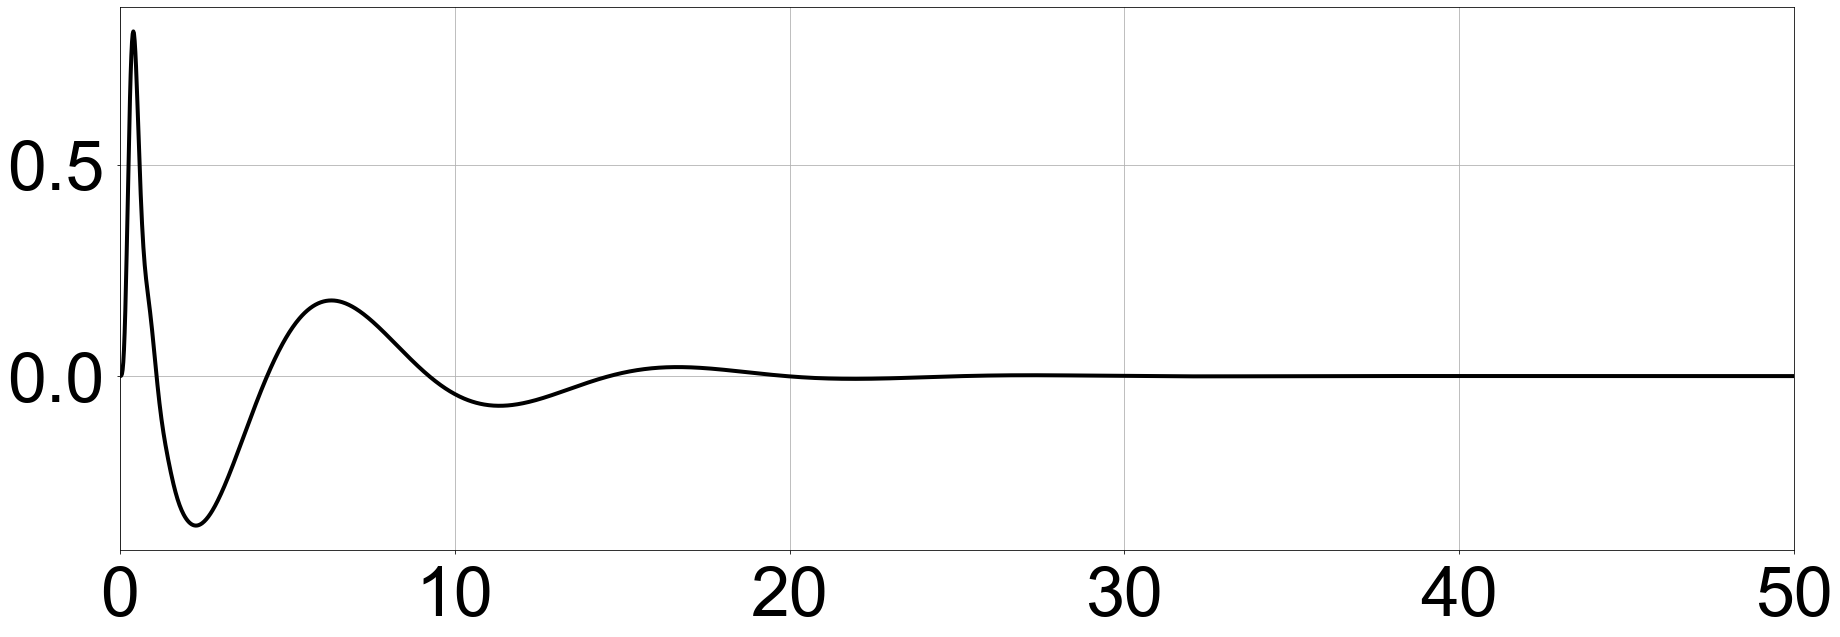

In [14]:
t=np.arange(0.0,tmax,dt)
stf=np.heaviside(t,0)
stf=bandpass(stf,freqmin=freqmin,freqmax=freqmax,df=1.0/dt,corners=4,zerophase=False)

plt.subplots(1, figsize=(30,10))
plt.plot(t,stf,'k',linewidth=4)
plt.xlim(0.0,50.0)
plt.grid()
plt.savefig('./OUTPUT/stf.png',format='png',dpi='figure')
plt.show()

## 3.2. Compute wavefield snapshot for selected time step

Just for visual inspection, we compute and plot the wavefield amplitude for a certain time step.

In [8]:
# Select time index and wavefield component.
time_index=3000
component=0

# Compute for each grid point.
ux=np.zeros(np.shape(xx))
amp=np.zeros(np.shape(xx))

for i in range(len(x)):
    for j in range(len(y)):
        
        u=SF(x[i],y[j],0.0,F,stf)[:][:]
        amp[j,i]=np.sqrt(u[0][time_index]**2+u[1][time_index]**2+u[2][time_index]**2)

In order to superimpose the fibre, we compute its geometry.

In [15]:
# Compute geometry of the fibre.
L=length(shape)
print(L)
s=np.linspace(0.0,L,ns+1)
[xh,yh,zh]=position(s,shape)

# Save fibre geometry.
np.save('./OUTPUT/xh.npy',xh)
np.save('./OUTPUT/yh.npy',yh)

1989205.8182


/var/folders/6r/8k4bk9516_lglt5l2j9q9gph0000gn/T/ipykernel_65435/2045117627.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([x,y,0])


Then we visualise the wavefield and the fibre.

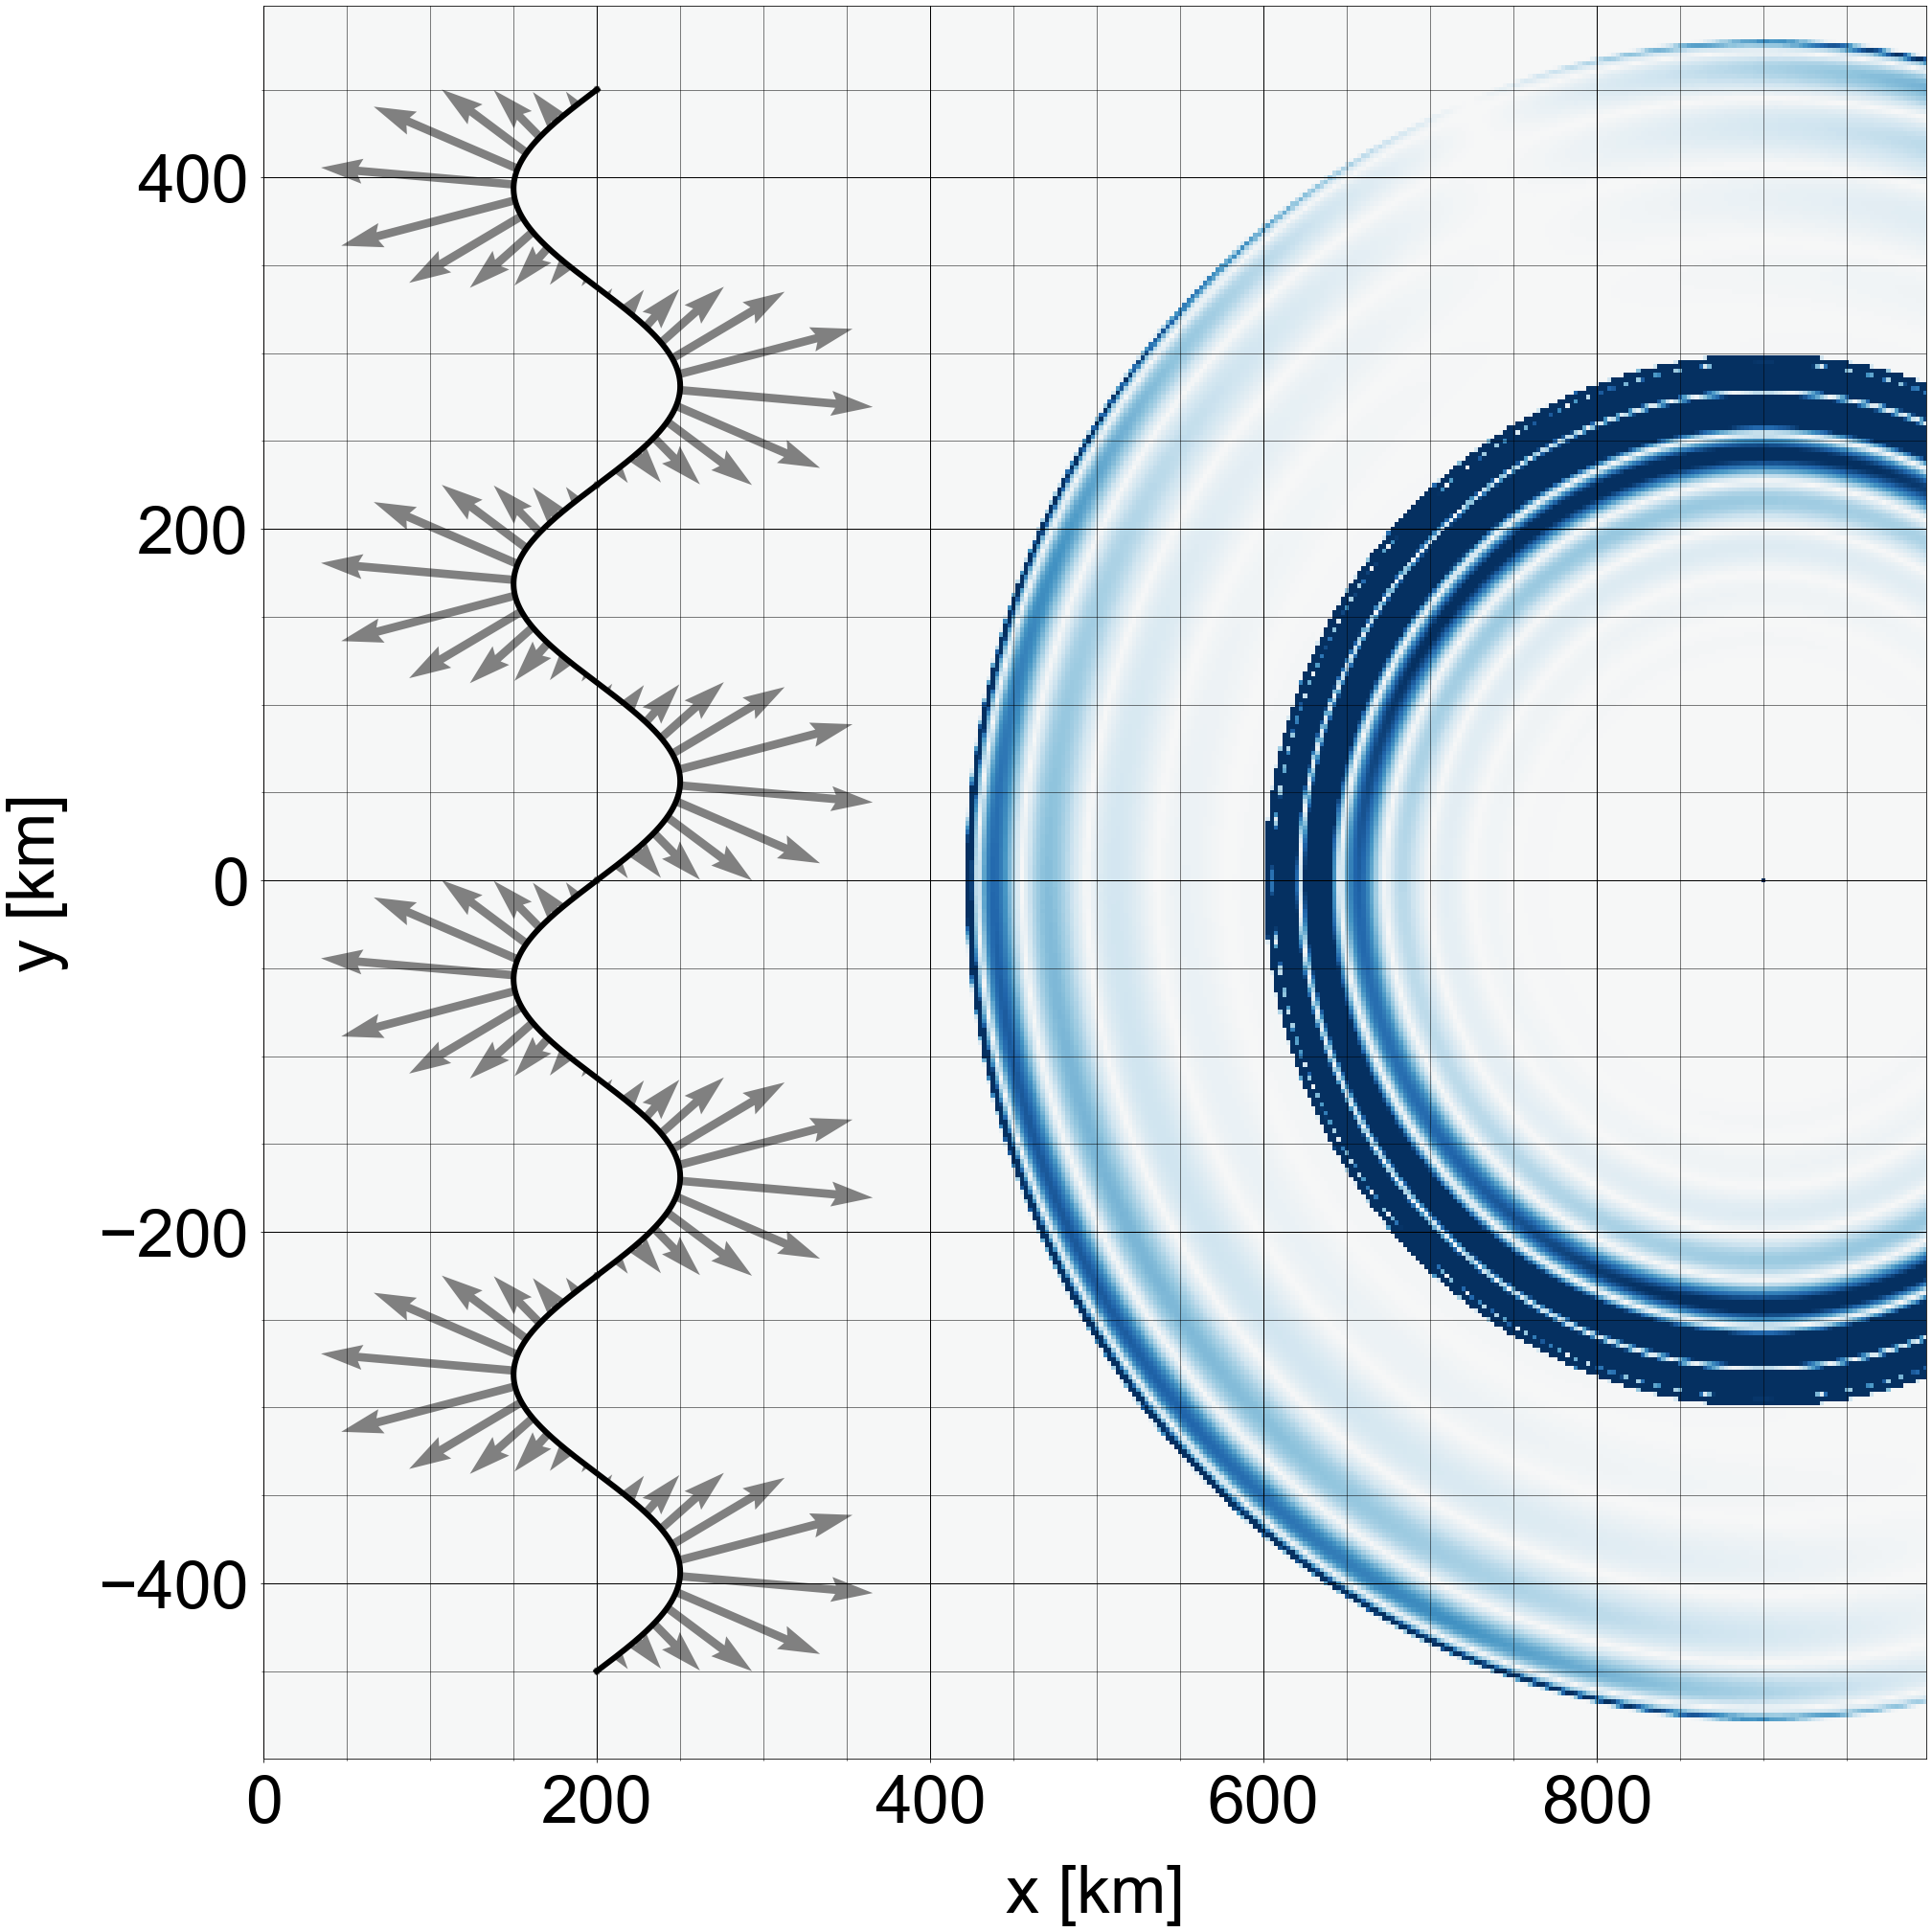

In [44]:
# Visualise wavefield and fibre.
plt.subplots(1, figsize=(3.0*(x[-1]-x[0])/1.0e5,3.0*(y[-1]-y[0])/1.0e5))
m=2.0e-13*np.max(np.abs(amp))
plt.pcolormesh(xx/1000.0,yy/1000.0,amp,vmin=-m,vmax=m,cmap='RdBu',shading='auto')
plt.plot(xh/1000.0,yh/1000.0,'k',linewidth=6)

# Visualise directional sensitivity.
for i in np.arange(0,len(s),100):
    [x0,y0,z0]=position(s[i],shape)
    [vx,vy,vz]=1.0e3*normal(s[i],shape)
    plt.quiver(x0/1000.0,y0/1000.0,-vx,-vy,scale=0.15,width=0.005,color=[0.5,0.5,0.5])
   
# Embellish the figure.
plt.xlim(x[0]/1000.0,x[-1]/1000.0)
plt.ylim(y[0]/1000.0,y[-1]/1000.0)
plt.xlabel('x [km]',labelpad=30)
plt.ylabel('y [km]',labelpad=30)
plt.tight_layout()
#plt.colorbar()
plt.minorticks_on()
plt.grid(which='major',color='k',linewidth=1.0)
plt.grid(which='minor',color='k',linewidth=0.5)
plt.savefig('./OUTPUT/forward_wavefield.png',format='png',dpi='figure')
plt.show()

## 4. Compute optical phase shifts

We compute optical phase shifts fist using a first-order approximation, and then without any approximation, i.e., including all higher-order effects.

In [56]:
ss=np.sqrt((900.0-150.0)**2+(390.0)**2)
print(ss)

845.340168216


In [57]:
print(1000.0*ss/vp)
print(1000.0*ss/vs)

105.667521027
169.068033643


In [55]:
769.0e3/vs

153.8

## 4.1. First-order calculation

In [45]:
# Allocate array.
theta_approx=np.zeros(len(t))

# Arc length increment.
ds=s[1]-s[0]

# Loop through sources.
for i in range(len(s)):
    
    [xhi,yhi,zhi]=position(s[i],shape)
    N=normal(s[i],shape)
    u=np.diff(SF(xhi,yhi,0.0,F,stf),append=0.0)/dt
    
    theta_approx+=N[0]*u[0]+N[1]*u[1]
    
theta_approx*=ds

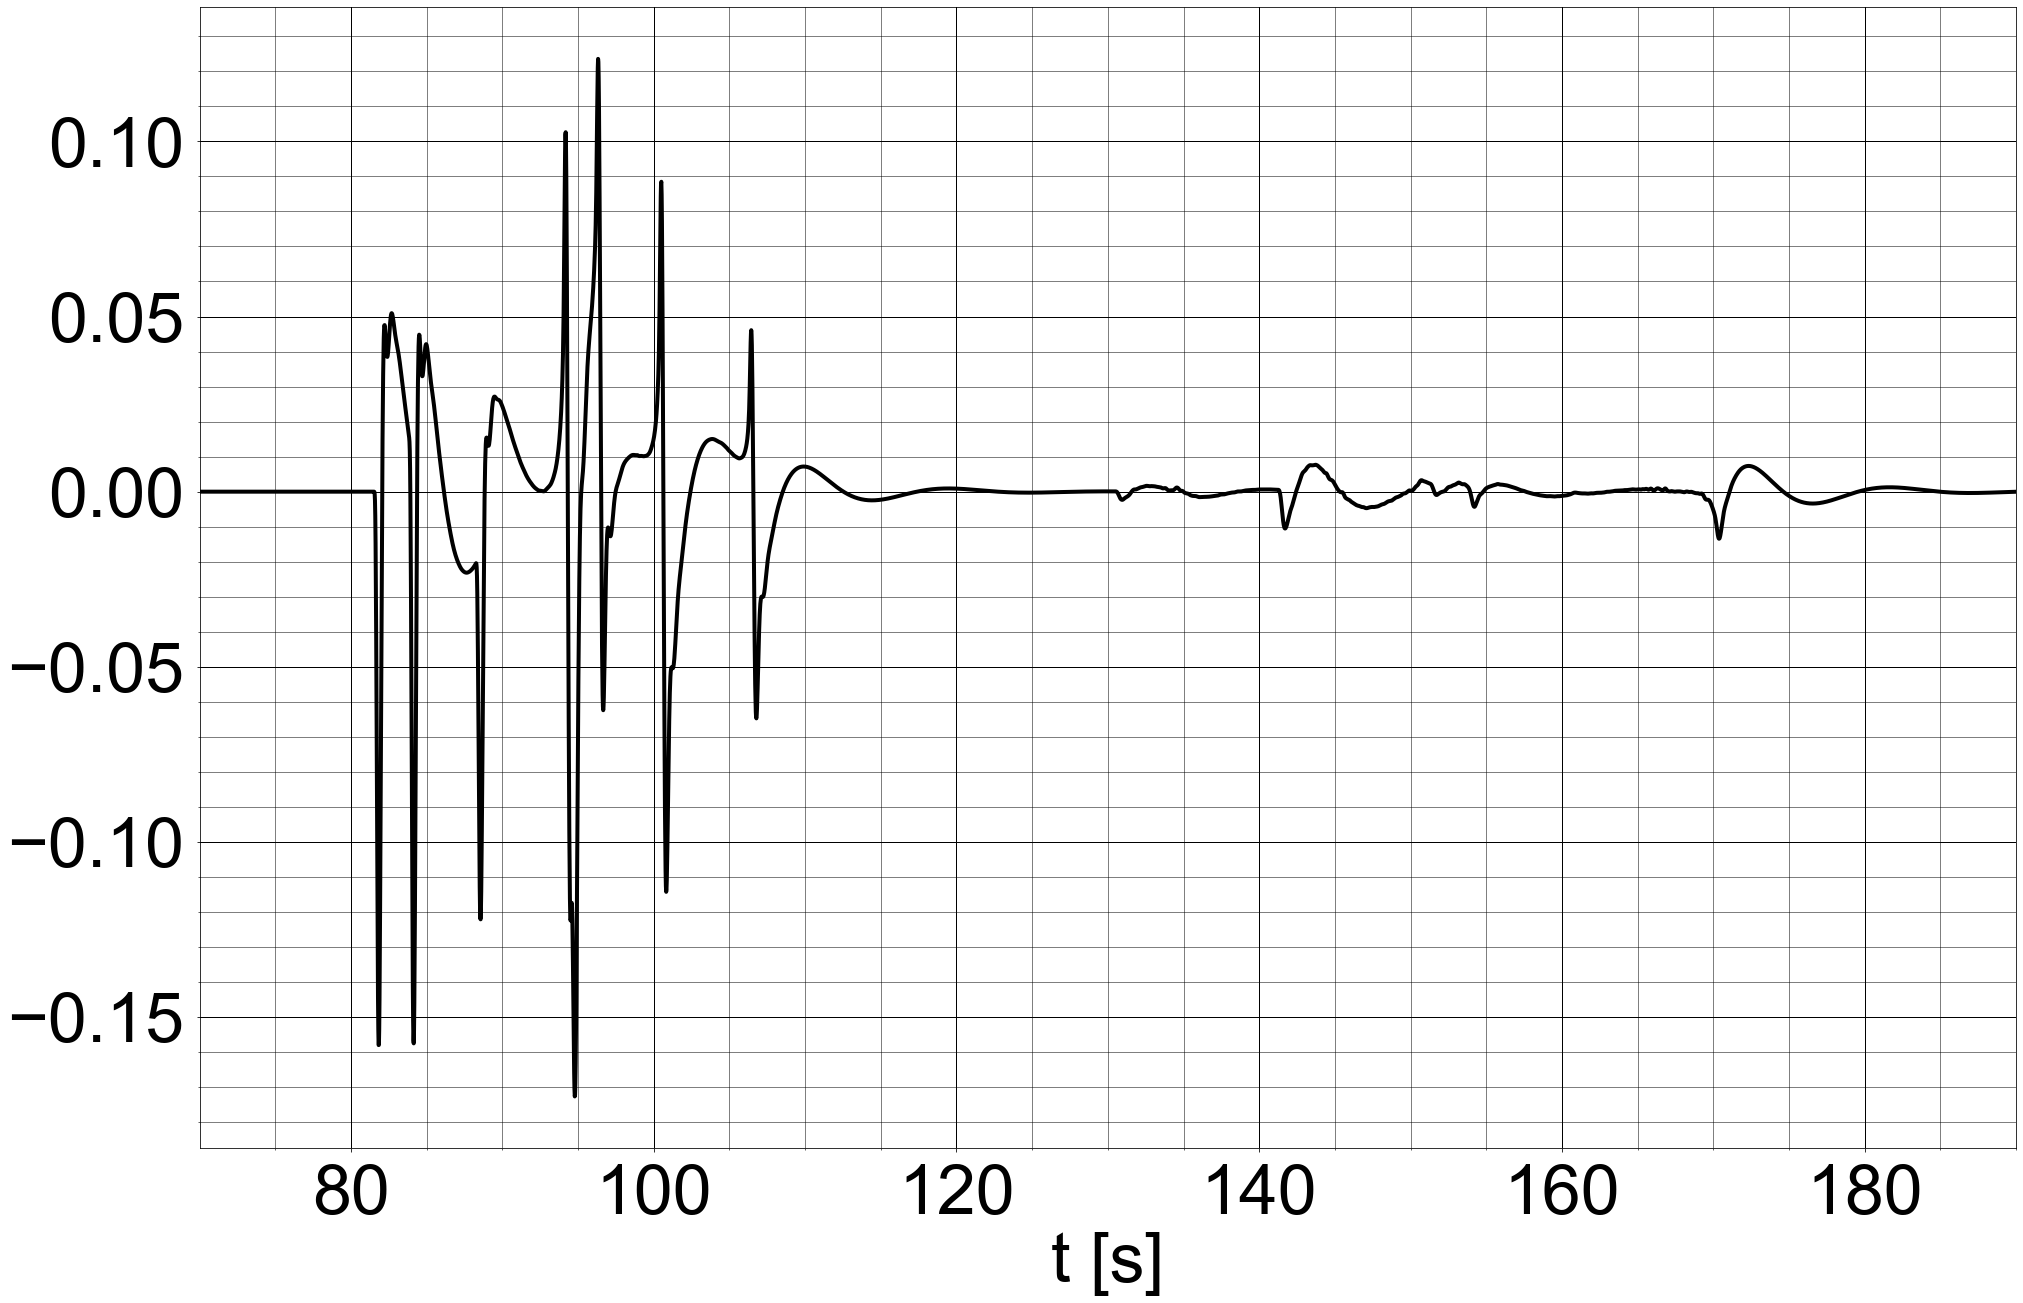

In [51]:
plt.subplots(1, figsize=(30,20))
plt.plot(t,theta_approx,'k',linewidth=4)
plt.xlim(0.0,t[len(t)-1])

#plt.xlim(80.0,105.0)

#plt.ylim(-2.0e-5,2.0e-5)
#plt.ylim(-3.0e-3,3.0e-3)
plt.xlim([70.0,190.0])
plt.xlabel('t [s]')
plt.minorticks_on()
plt.grid(which='major',color='k',linewidth=1.0)
plt.grid(which='minor',color='k',linewidth=0.5)
plt.tight_layout()
plt.savefig('./OUTPUT/phase_shift.png',format='png',dpi='figure')
plt.show()

## 4.2. Exact calculation

In [ ]:
# Allocate array.
theta_exact=np.zeros(len(t))

# Arc length increment.
ds=s[1]-s[0]

# Loop through sources.
for i in range(len(s)):
    
    [xhi,yhi,zhi]=position(s[i],shape)
    e=tangent(s[i],shape)
    u=DC(xhi,yhi,0.0,F,e,stf)
    
    theta_exact+=np.sqrt((e[0]+u[0])**2 + (e[1]+u[1])**2 + (e[2]+u[2])**2)
    
theta_exact*=ds
theta_exact=-np.diff(theta_exact,append=0.0)/dt

In [ ]:
plt.subplots(1, figsize=(40,10))
plt.plot(t,theta_exact,'k',linewidth=4)
plt.xlim(0.0,t[len(t)-1])
plt.xlabel('t [s]')
plt.minorticks_on()
plt.grid(which='major',color='k',linewidth=1.0)
plt.grid(which='minor',color='k',linewidth=0.5)
plt.tight_layout()
plt.savefig('./OUTPUT/phase_shift.png',format='png',dpi='figure')
plt.show()

In [ ]:
plt.subplots(1, figsize=(40,15))

theta_exact[-1]=0.0
plt.plot(t,theta_exact,'k',linewidth=6)
plt.plot(t,theta_approx,'--r',linewidth=6)

#plt.xlim(0.0,t[len(t)-1])
plt.xlim(0.0,200.0)
plt.ylim(-5e-6,5e-6)

plt.xlabel('t [s]')
plt.minorticks_on()
plt.grid(which='major',color='k',linewidth=1.0)
plt.grid(which='minor',color='k',linewidth=0.5)
plt.tight_layout()
plt.savefig('./OUTPUT/phase_shift.png',format='png',dpi='figure')
plt.show()